In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import simulation_utils as su
import importlib

In [24]:
# Define some parameters

w0 = 55000*2*np.pi # Natural frequency of oscillator
P = 1*10**(-7) # Pressure in mbar
T = 293 # Environmental temperature
R = (0.083)*10**(-6) # Particle Radius
p = 2200 # Particle Denisty
dtn = 1*10**(-8) # Timestep
M = 4/3*np.pi*R**3*p # Particle mass
kb = 1.38*10**(-23) # Boltzmann constant
m = 29*1.67*10**(-27) # average mass of air particles
v = np.sqrt(8*1.38*10**(-23)*T/(np.pi*m)) # velocity of air particles
N0 = 2.43*10**(25) # Number density of air and ambient pressure
P0 = 1000 # Ambient pressure
N=N0*P/P0 # Number density of air at pressure P

y = (4/3*np.pi)*(m*v*N*R**2)/(M) # Damping from air
#y = 4.10568*1e-6*P*1e2/R # Antonio's damping from air

print(y)

Snn = 10**(-28) # Displacement noise

0.00029717080823618027


In [25]:
maxw = 5*10**5 # 500 kHz is enough to capture all dynamics
yfb = 1*2*np.pi
numbins = int(2*5*10**4*100*2*np.pi/yfb) # This is to ensure the particle amplitude decays to thermal levels
w = np.linspace(0, maxw*2*np.pi, numbins)

# Generate some random number seeds
np.random.seed(85655219)
random_nums = np.random.uniform(0, 1000000, 3) # These are the seeds we will use

randomlist, randomlist2, randomlist3 = su.generate_random_numbers(random_nums[0:3], Snn, numbins, maxw)
x = su.generate_displacement_fm(w, w0, y, yfb, M, T, randomlist, randomlist2, randomlist3, np.zeros(numbins), 0.01, 0)

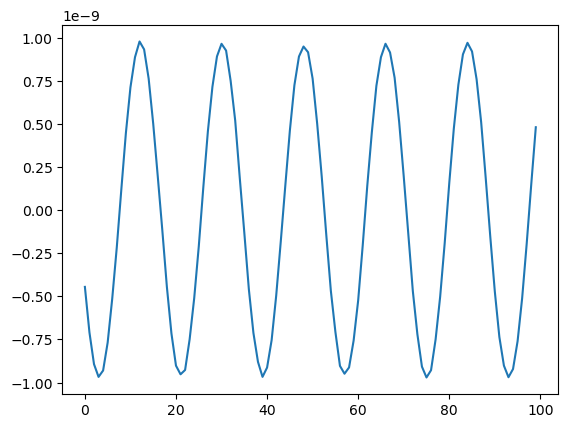

In [26]:
plt.plot(x[0][:100])

In [27]:
PSD = scisig.welch(x[0], fs = 10**6, nperseg = 10**6, window = 'boxcar')

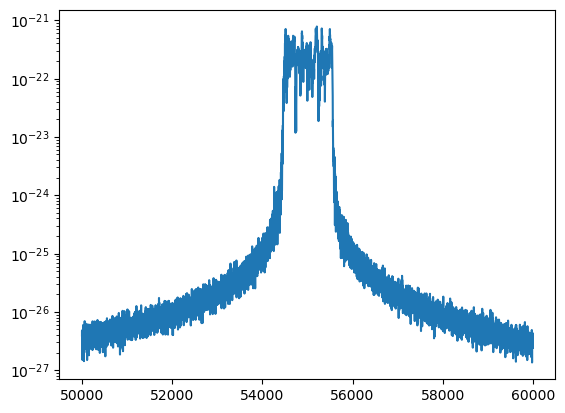

In [28]:
lb = int(1*50000)
ub = int(1*60000)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.yscale('log')

In [29]:
time, R2, R2_filt, theta_filt = au.lockin(x[0][:10**7], 10**6, 55000, 10000, 20000, 10, 'R')

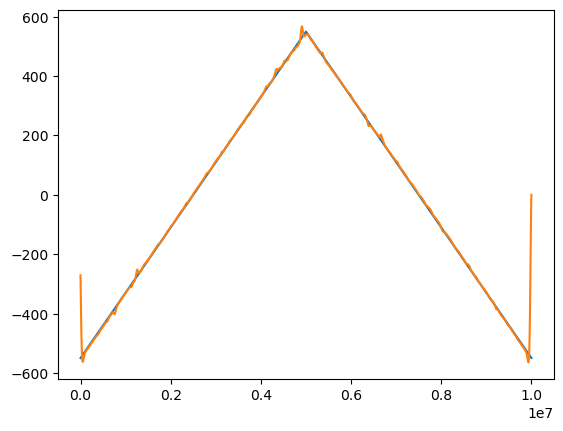

In [30]:
lb = 0
ub = -1
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.01, 0)
plt.plot(mod*55000-55000)
plt.plot(np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi)

In [31]:
w_est = np.gradient(theta_filt, 10**(-6))[lb:ub]/2/np.pi/55000+1

In [32]:
theta_est = []
area = 0
for i in range(len(w_est)):
    area += np.trapz(w_est[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    theta_est.append(area)

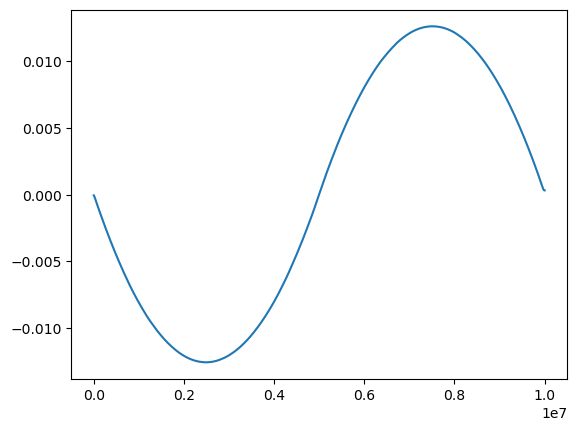

In [85]:
#plt.plot(np.array(theta_est)*2*np.pi*55000)
plt.plot(theta_filt/2/np.pi/55000)

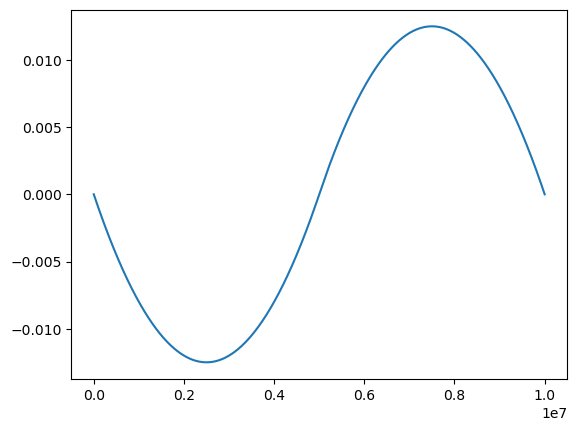

In [83]:
plt.plot(x[2]-x[1])

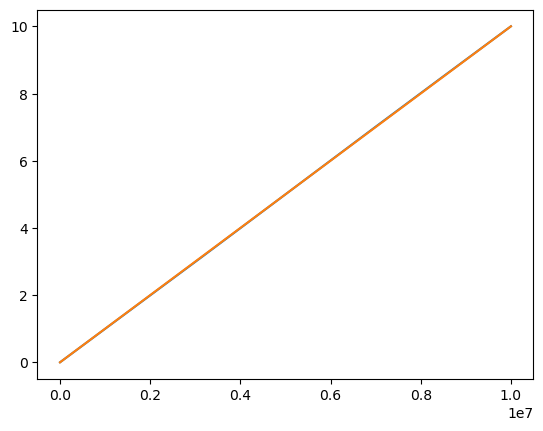

In [87]:
time = np.linspace(1*10**(-6), 10, 10**7-1)
plt.plot((theta_filt/2/np.pi/55000)+time)
plt.plot(time)

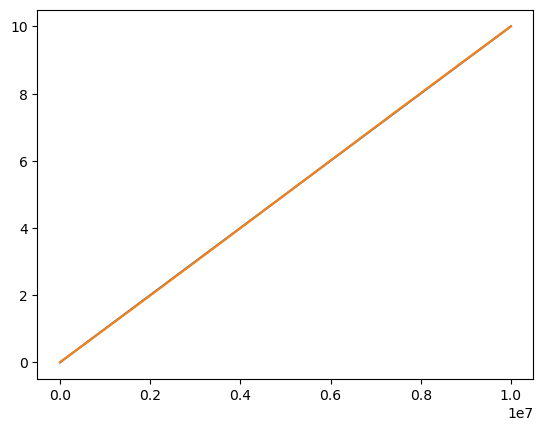

In [78]:
plt.plot(x[1])
plt.plot(x[2])

In [46]:
len(x[0])
len(x[1])

10000000

In [71]:
theta_est

[1.990140770662846e-06,
 3.980281207547027e-06,
 5.970421199392576e-06,
 7.96056074619887e-06,
 9.950699847965285e-06,
 1.1940838504691202e-05,
 1.3930976716376018e-05,
 1.5921114483019136e-05,
 1.7911251804619936e-05,
 1.99013886811778e-05,
 2.189152511269214e-05,
 2.3881661099162363e-05,
 2.5871796640587858e-05,
 2.7861931736968015e-05,
 2.985206638830225e-05,
 3.184220059458997e-05,
 3.383233435583056e-05,
 3.5822467672023446e-05,
 3.781260054316803e-05,
 3.980273296926372e-05,
 4.179286495030993e-05,
 4.378299648630609e-05,
 4.5773127577251616e-05,
 4.776325822314592e-05,
 4.975338842398843e-05,
 5.174351817977856e-05,
 5.3733647490515735e-05,
 5.572377635619938e-05,
 5.771390477682891e-05,
 5.9704032752403765e-05,
 6.169416028292336e-05,
 6.368428736838712e-05,
 6.567441400879449e-05,
 6.766454020414489e-05,
 6.965466595443778e-05,
 7.164479125967258e-05,
 7.363491611984874e-05,
 7.562504053496576e-05,
 7.761516450502304e-05,
 7.960528803002005e-05,
 8.159541110995621e-05,
 8.3585

In [88]:
x_mod = su.frequency_modulation(x[0], x[2], x[1])
x_mod2 = su.frequency_modulation(x[0], (theta_filt/2/np.pi/55000)+time, x[1])

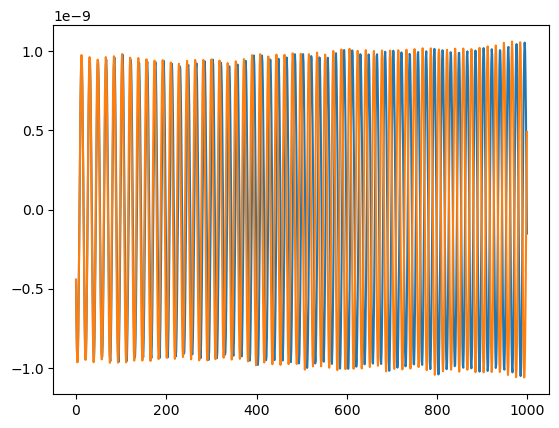

In [80]:
plt.plot(x_mod[:1000])
plt.plot(x[0][:1000])

In [89]:
PSD_mod = scisig.welch(x_mod, fs = 10**6, nperseg = 10**6, window = 'boxcar')
PSD_mod2 = scisig.welch(x_mod2, fs = 10**6, nperseg = 10**6, window = 'boxcar')

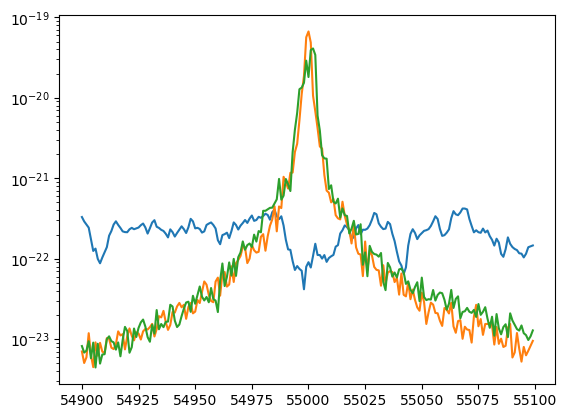

In [92]:
lb = int(1*54900)
ub = int(1*55100)
plt.plot(PSD[0][lb:ub], PSD[1][lb:ub])
plt.plot(PSD_mod[0][lb:ub], PSD_mod[1][lb:ub])
plt.plot(PSD_mod2[0][lb:ub], PSD_mod2[1][lb:ub])
plt.yscale('log')

In [52]:
time2 = su.generate_sawtooth_frequency_modulation(np.linspace(0, 10, 10**7), 0.01, 0)
mod = su.generate_sawtooth_frequency_modulation_impulse(np.linspace(0, 10, 10**7), 0.01, 0)

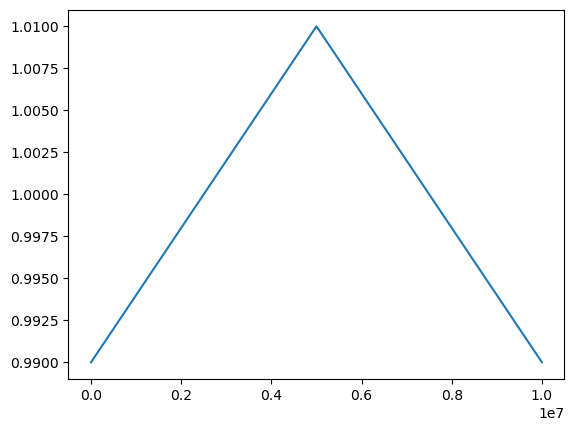

In [53]:
plt.plot(mod)

In [54]:
foo = []
area = 0
for i in range(len(mod)):
    area += np.trapz(mod[i:i+2], np.linspace(10**(-6)*i, 10**(-6)*(i+2), 2))
    foo.append(area)

In [55]:
plt.plot(foo)

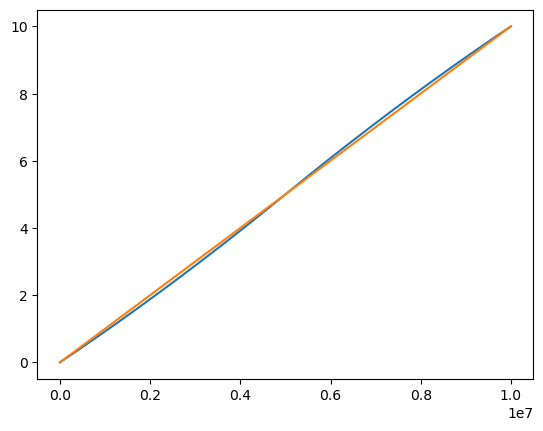

In [ ]:

plt.plot(np.array(foo)/2)
plt.plot(np.linspace(0, 10, 10**7))
#plt.plot(time2)

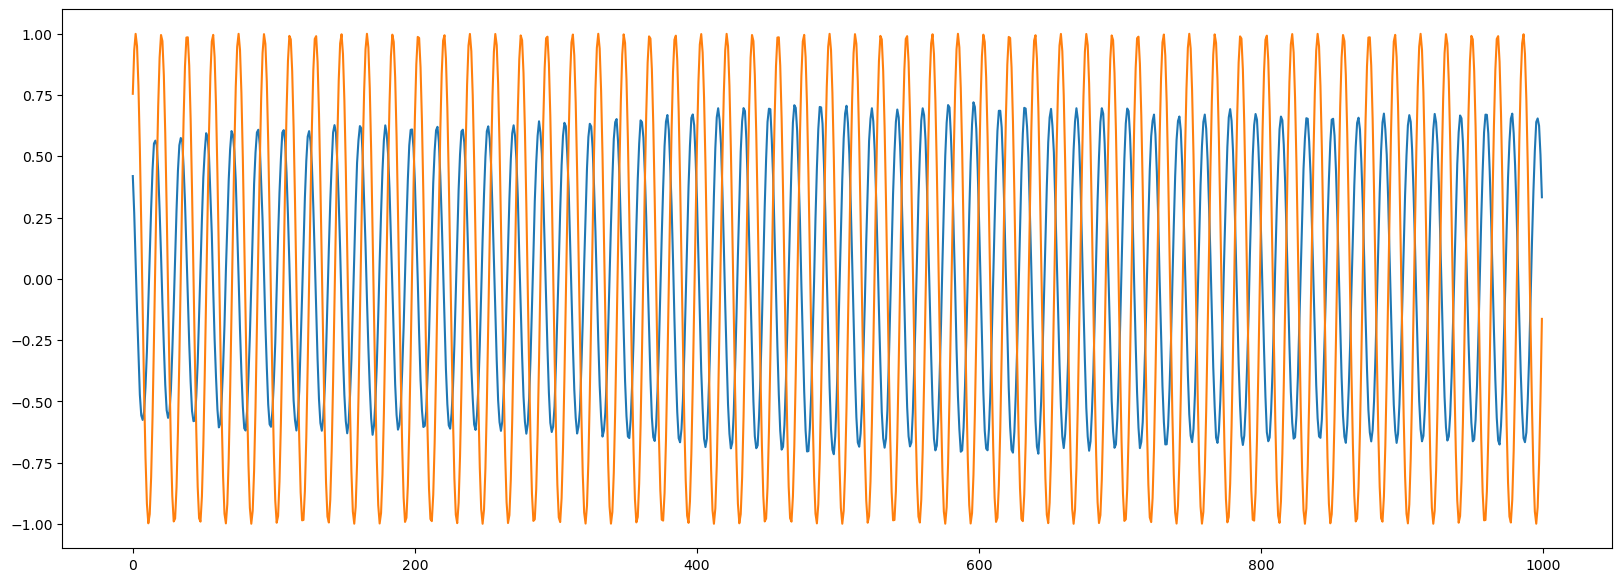

In [59]:
lb = -int(8*10**6)
ub = lb+1000 
plt.figure(figsize = (20, 7))
plt.plot(x[lb:ub]*10**9)
#plt.plot(np.sin((55000*2*np.pi+theta_filt[:-1]+(theta_filt[1:] - theta_filt[:-1])*10**6)*np.linspace(2*10**(-6), 10, 10**7-2))[lb:ub])
plt.plot(np.sin((55000*2*np.pi)*np.linspace(1*10**(-6), 10, 10**7-1)+theta_filt)[lb:ub])

In [100]:
np.std((theta_filt[1:] - theta_filt[:-1])*10**6/2/np.pi/2)

0.26801164045959797